In [102]:
# all this code was borrowed from 
# https://towardsdatascience.com/how-i-used-machine-learning-to-automatically-hand-draw-any-picture-7d024d0de997
import cv2;
from matplotlib import pyplot as plt
import numpy as np
import pyautogui as pg
import kdtree
import operator
from cnc import CNC
from sklearn.cluster import KMeans
from collections import defaultdict

class AutoDraw(object):
    def __init__(self, name, blur = 0):
        # Tunable parameters
        self.detail = 1
#         self.scale = 7/12
        self.scale = 1
        self.sketch_before = False
        self.with_color = True
        self.num_colors = 10
        self.outline_again = False

        # Load Image. Switch axes to match computer screen
        self.img = cv2.imread(name)
        self.blur = blur
        self.img = np.swapaxes(self.img, 0, 1)
        self.img_shape = self.img.shape

#         self.dim = pg.size()

        # 30 cm x 18 cm
        xRatio = 18/30
        yDim = 165
        xDim = yDim * xRatio
        self.dim = (yDim, xDim)

        # Scale to draw inside part of screen
        self.startX = ((1 - self.scale) / 2)*self.dim[0] 
        self.startY = ((1 - self.scale) / 2)*self.dim[1]
#         self.dim = (self.dim[0] * self.scale, self.dim[1] * self.scale)

#         fit the picture into this section of the screen
        if self.img_shape[1] > self.img_shape[0]:
            # if it's taller that it is wide, truncate the wide section
            self.dim = (int(self.dim[1] * (self.img_shape[0] / self.img_shape[1])), self.dim[1])
        else:
            # if it's wider than it is tall, truncate the tall section
            self.dim = (self.dim[0], int(self.dim[0] *(self.img_shape[1] / self.img_shape[0])))

        # Get dimension to translate picture. Dimension 1 and 0 are switched due to comp dimensions
        ratio = self.img.shape[0] / self.img.shape[1]
        pseudo_x = int(self.img.shape[1] * self.detail)
        self.pseudoDim = (pseudo_x, int(pseudo_x * ratio))
        
          # Initialize directions for momentum when creating path
        self.maps = {0: (1, 1), 1: (1, 0), 2: (1, -1), 3: (0, -1), 4: (0, 1), 5: (-1, -1), 6: (-1, 0), 7: (-1, 1)}
        self.momentum = 1
        self.curr_delta = self.maps[self.momentum]

        # Create Outline
        self.drawing = self.process_img(self.img)
        plt.imshow(self.drawing)
        plt.show()

    def rescale(self, img, dim):
        resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        return resized

    def translate(self, coord):
        ratio = (coord[0] / self.pseudoDim[1], coord[1] / self.pseudoDim[0]) # this is correct
        deltas = (int(ratio[0] * self.dim[0]), int(ratio[1] * self.dim[1]))
        return self.startX + deltas[0], self.startY + deltas[1]
    
    def process_img(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if self.blur == 2:
            gray = cv2.GaussianBlur(gray, (9, 9), 0)
            canny = cv2.Canny(gray, 25, 45)
        elif self.blur == 1:
            gray = cv2.GaussianBlur(gray, (3, 3), 0)
            canny = cv2.Canny(gray, 25, 45)
        else:  # no blur
            canny = cv2.Canny(gray, 50, 75)
        canny = self.rescale(canny, self.pseudoDim)
        r, res = cv2.threshold(canny, 50, 255, cv2.THRESH_BINARY_INV)

        return res
    
    def drawOutline(self):
        indices = np.argwhere(self.drawing < 127).tolist()  # get the black colors
        index_tuples = map(tuple, indices)

        self.hashSet = set(index_tuples)
        self.KDTree = kdtree.create(indices)
#         self.KDTree = KDTree(indices)
        self.commands = []
        self.curr_pos = (0, 0)
        point = self.translate(self.curr_pos)
        self.commands.append(point)

#         print('Please change pen to thin and color to black.')
#         input("Press enter once ready")
#         print('')

        # DRAW THE BLACK OUTLINE
        self.createPath()
#         self.cleanCommands()
        return self.commands
#         print(self.commands)
#         input("Ready! Press Enter to draw")
#         print('5 seconds until drawing beings')
#         time.sleep(5)

#         self.execute(self.commands)

    def createPath(self):
        # check for closest point. Go there. Add click down. Change curr. Remove from set and tree. Then, begin
        new_pos = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#         print(self.curr_pos[0)
#         new_pos = tuple(self.KDTree.query(self.curr_pos)[0].data)
        self.commands.append(new_pos)
        self.commands.append("DOWN")
        self.curr_pos = new_pos
        self.KDTree = self.KDTree.remove(list(new_pos))
        self.hashSet.remove(new_pos)

        while len(self.hashSet) > 0:
            prev_direction = self.momentum
            candidate = self.checkMomentum(self.curr_pos)
            if self.isValid(candidate):
                new = tuple(map(operator.add, self.curr_pos, candidate))
                new_pos = self.translate(new)
                if prev_direction == self.momentum and type(self.commands[-1]) != str:  # the direction didn't change
                    self.commands.pop()
                self.commands.append(new_pos)
            else:
                self.commands.append("UP")
                new = tuple(self.KDTree.search_nn(self.curr_pos)[0].data)
#                 new = tuple(self.KDTree.query(self.curr_pos)[0].data)
                new_pos = self.translate(new)
                self.commands.append(new_pos)
                self.commands.append("DOWN")
            self.curr_pos = new
            self.KDTree = self.KDTree.remove(list(new))
            self.hashSet.remove(new)
#             print('Making path...number points left: ', len(self.hashSet))
        return

#     def cleanCommands(self):
#         self.commands = self.commands[2:]
#         for command in self.commands:
#             if(type(command) is not str):
#                 command[0] -= 25
#                 command[1] -=25

    def isValid(self, delta):
        return len(delta) == 2

    def checkMomentum(self, point):
        # Returns best next relative move w.r.t. momentum and if in hashset
        self.curr_delta = self.maps[self.momentum]
        moments = self.maps.values()
        deltas = [d for d in moments if (tuple(map(operator.add, point, d)) in self.hashSet)]
        deltas.sort(key=self.checkDirection, reverse=True)
        if len(deltas) > 0:
            best = deltas[0]
            self.momentum = [item[0] for item in self.maps.items() if item[1] == best][0]
            return best
        return [-1]

    def checkDirection(self, element):
        return self.dot(self.curr_delta, element)

    def dot(self, pt1, pt2):
        pt1 = self.unit(pt1)
        pt2 = self.unit(pt2)
        return pt1[0] * pt2[0] + pt1[1] * pt2[1]

    def unit(self, point):
        norm = (point[0] ** 2 + point[1] ** 2)
        norm = np.sqrt(norm)
        return point[0] / norm, point[1] / norm
    
    def draw(self):
        if self.with_color:
            color = self.rescale(self.img, self.pseudoDim)
            collapsed = np.sum(color, axis=2)/3
            fill = np.argwhere(collapsed < 230)  # color 2-d indices
            fill = np.swapaxes(fill, 0, 1)  # swap to index into color
            RGB = color[fill[0], fill[1], :]
            k_means = KMeans(n_clusters=self.num_colors).fit(RGB)
            colors = k_means.cluster_centers_
            labels = k_means.labels_
            fill = np.swapaxes(fill, 0, 1).tolist()  # swap back to make dictionary
            label_2_index = defaultdict(list)

            for i, j in zip(labels, fill):
                label_2_index[i].append(j)
            
            
            for (i, color) in enumerate(colors):
                
                print(color[2])
                print(color[1])
                print(color[0])
                print("\n")
                # Grayscale conversion formula found at 
                # https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/
                grayscale = 0.299 * color[2] + 0.587 * color[1] + 0.114 * color[0]
#                 print(grayscale)
#                 print('Please change the pen to thick and color to BGR (not RGB) values: ', color)
#                 input("Press enter once ready")
#                 print('')

                points = label_2_index[i]
                index_tuples = map(tuple, points)
                self.hashSet = set(index_tuples)
                self.KDTree = kdtree.create(points)
                self.commands = []
                self.curr_pos = (0, 0)
                point = self.translate(self.curr_pos)
                self.commands.append(point)
                self.commands.append("UP")
                if(color[2] >= color[1] and color[2] >= color[0]):
                    print("test")
                    self.commands.append("BLUE");
                if(color[1] >= color[2] and color[1] >= color[0]):
                    self.commands.append("GREEN");
                if(color[0] >= color[2] and color[0] >= color[1]):
                    self.commands.append("RED");
                self.createPath()

#                 input('Ready! Press enter to draw: ')
#                 print('5 seconds until drawing begins...')
#                 time.sleep(5)
#                 self.execute(self.commands)
            return self.commands
            if self.outline_again:
                self.drawOutline()

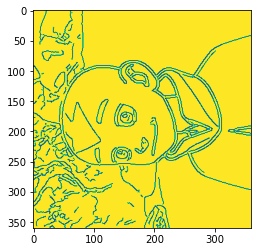

253.37010501521246
212.66463833546004
135.92688193149513


test
210.3652093023256
68.6656124030995
18.691162790696097


test
50.87670601254314
22.7990593876776
2.952508299517689


test
250.9449243605411
179.08061185790692
102.67443428427005


test
146.8552698358992
101.60979529690431
54.66536964980572


test
184.63455056179774
133.3641853932584
80.00617977528081


test
112.62982090795462
70.35360266555614
30.582423990004607


test
229.06790291791657
138.70275429506404
26.593946004908986


test
254.77055186627052
244.51503702007756
176.68094038622615


test
178.1860622462787
161.69451962110983
150.36941813261225


test


In [103]:
drawing = AutoDraw("./aang.png", blur=2)
commands = drawing.draw()


In [104]:
print(commands)

[(0.0, 0.0), 'UP', 'BLUE', (66, 82), 'DOWN', 'UP', (44.0, 43.0), 'DOWN', (44.0, 44.0), 'UP', (45.0, 40.0), 'DOWN', (46.0, 39.0), 'UP', (47.0, 38.0), 'DOWN', 'UP', (48.0, 36.0), 'DOWN', 'UP', (49.0, 35.0), 'DOWN', (49.0, 34.0), 'UP', (50.0, 33.0), 'DOWN', (50.0, 33.0), 'UP', (60.0, 27.0), 'DOWN', 'UP', (67.0, 24.0), 'DOWN', 'UP', (75.0, 22.0), 'DOWN', (75.0, 22.0), (89.0, 22.0), (105.0, 38.0), (105.0, 39.0), (95.0, 49.0), (95.0, 49.0), (78.0, 32.0), (78.0, 31.0), (98.0, 31.0), (104.0, 38.0), (104.0, 39.0), (95.0, 48.0), (95.0, 48.0), (78.0, 32.0), (74.0, 36.0), (71.0, 33.0), (71.0, 33.0), (77.0, 33.0), (88.0, 44.0), (90.0, 44.0), (93.0, 47.0), 'UP', (93.0, 46.0), 'DOWN', (95.0, 48.0), (95.0, 48.0), (104.0, 39.0), (104.0, 38.0), (98.0, 32.0), (79.0, 32.0), (93.0, 46.0), (97.0, 46.0), (104.0, 39.0), (104.0, 38.0), (98.0, 32.0), (80.0, 32.0), (93.0, 45.0), (97.0, 45.0), (103.0, 39.0), (103.0, 38.0), (98.0, 33.0), (81.0, 33.0), (93.0, 45.0), (97.0, 45.0), (103.0, 39.0), (103.0, 38.0), (98.0

In [62]:
cnc = CNC()
cnc.open("./test.gcode")

# cnc.render_text_file(open("./test.txt", "r"), 5)
cnc.g90()
cnc.g0(z=5)
cnc.f(3000)
cnc.g0(z=5)
# cnc.g1(z=0)
prevNonUpOrDownCommand = (0, 0)
newCommands = [] 
for index in range(len(commands)):
    if(prevNonUpOrDownCommand == commands[index]):
        continue
    if commands[index] == 'UP':
        if commands[index + 1] != 'UP' and commands[index + 1] != 'DOWN':
            newCommands.append(commands[index])
#             cnc.up()
    elif commands[index] == 'DOWN':
        if commands[index + 1] != 'UP' and commands[index + 1] != 'DOWN':
            newCommands.append(commands[index])
#             cnc.down()
    else:
#         cnc.g1(x=commands[index][1] - 15,y=-commands[index][0] + 15)
        newCommands.append(commands[index])
        prevNonUpOrDownCommand = commands[index]

for index in range(len(newCommands)):
    if newCommands[index] == 'UP':
        if newCommands[index + 1] != 'UP' and newCommands[index + 1] != 'DOWN':
#             newCommands.append(commands[index])
            cnc.up()
    elif newCommands[index] == 'DOWN':
        if newCommands[index + 1] != 'UP' and newCommands[index + 1] != 'DOWN':
#             newCommands.append(commands[index])
            cnc.down()
    else:
        cnc.g1(x=newCommands[index][1],y=-newCommands[index][0])
#         newCommands.append(commands[index])
#         prevNonUpOrDownCommand = commands[index]

cnc.close()

G90 
G0 Z5
F3000
G0 Z5
G1 X20 Y-6
G1 Z0
G1 X9.0 Y-3.0
G1 X8.0 Y-4.0
G1 X8.0 Y-5.0
G1 X7.0 Y-6.0
G1 X7.0 Y-7.0
G1 X6.0 Y-8.0
G1 X6.0 Y-9.0
G1 X6.0 Y-10.0
G1 X5.0 Y-11.0
G1 X5.0 Y-12.0
G1 X5.0 Y-15.0
G1 X5.0 Y-16.0
G1 X5.0 Y-17.0
G1 X5.0 Y-19.0
G1 X5.0 Y-20.0
G1 X5.0 Y-21.0
G1 X5.0 Y-22.0
G1 X5.0 Y-23.0
G1 X5.0 Y-25.0
G0 Z1
G1 X6.0 Y-22.0
G1 Z0
G1 X7.0 Y-20.0
G1 X8.0 Y-19.0
G1 X10.0 Y-19.0
G1 X13.0 Y-19.0
G1 X14.0 Y-20.0
G1 X16.0 Y-20.0
G1 X16.0 Y-21.0
G1 X17.0 Y-21.0
G1 X18.0 Y-20.0
G1 X18.0 Y-21.0
G1 X19.0 Y-21.0
G1 X20.0 Y-22.0
G1 X21.0 Y-22.0
G1 X22.0 Y-23.0
G0 Z1
G1 X23.0 Y-23.0
G1 Z0
G1 X25.0 Y-21.0
G1 X26.0 Y-21.0
G1 X27.0 Y-20.0
G1 X27.0 Y-19.0
G1 X25.0 Y-17.0
G1 X24.0 Y-17.0
G0 Z1
G1 X24.0 Y-16.0
G1 Z0
G1 X23.0 Y-16.0
G1 X23.0 Y-15.0
G1 X24.0 Y-15.0
G1 X23.0 Y-14.0
G1 X24.0 Y-14.0
G1 X24.0 Y-13.0
G1 X25.0 Y-11.0
G1 X27.0 Y-9.0
G1 X27.0 Y-8.0
G1 X28.0 Y-8.0
G1 X29.0 Y-7.0
G1 X29.0 Y-6.0
G1 X28.0 Y-6.0
G1 X28.0 Y-5.0
G1 X28.0 Y-4.0
G1 X27.0 Y-4.0
G1 X27.0 Y-2.0
G1 X28.0 Y-2.0
G1 X

G1 Z0
G1 X33.0 Y-130.0
G0 Z1
G1 X33.0 Y-132.0
G1 Z0
G1 X31.0 Y-132.0
G1 X30.0 Y-132.0
G1 X29.0 Y-132.0
G1 X27.0 Y-129.0
G1 X26.0 Y-129.0
G1 X25.0 Y-129.0
G1 X24.0 Y-128.0
G1 X23.0 Y-128.0
G1 X22.0 Y-127.0
G1 X21.0 Y-126.0
G1 X20.0 Y-126.0
G1 X19.0 Y-127.0
G1 X19.0 Y-128.0
G1 X20.0 Y-130.0
G1 X21.0 Y-131.0
G1 X21.0 Y-132.0
G1 X21.0 Y-133.0
G1 X20.0 Y-135.0
G1 X19.0 Y-135.0
G1 X18.0 Y-133.0
G1 X18.0 Y-134.0
G1 X16.0 Y-135.0
G1 X16.0 Y-136.0
G1 X15.0 Y-136.0
G1 X14.0 Y-137.0
G1 X15.0 Y-138.0
G1 X16.0 Y-140.0
G1 X15.0 Y-139.0
G0 Z1
G1 X16.0 Y-139.0
G0 Z1
G1 X15.0 Y-137.0
G0 Z1
G1 X14.0 Y-135.0
G1 Z0
G1 X13.0 Y-134.0
G1 X12.0 Y-134.0
G1 X11.0 Y-133.0
G1 X11.0 Y-134.0
G1 X10.0 Y-134.0
G1 X7.0 Y-137.0
G1 X6.0 Y-138.0
G1 X6.0 Y-137.0
G0 Z1
G1 X7.0 Y-137.0
G1 Z0
G1 X10.0 Y-134.0
G0 Z1
G1 X8.0 Y-132.0
G1 Z0
G1 X9.0 Y-131.0
G1 X9.0 Y-130.0
G1 X11.0 Y-129.0
G1 X11.0 Y-128.0
G1 X11.0 Y-127.0
G1 X12.0 Y-126.0
G1 X13.0 Y-126.0
G1 X14.0 Y-126.0
G1 X15.0 Y-126.0
G1 X16.0 Y-124.0
G1 X17.0 Y-124.0
G1 X18

G1 Z0
G1 X75.0 Y-53.0
G0 Z1
G1 X74.0 Y-53.0
G1 Z0
G1 X73.0 Y-52.0
G0 Z1
G1 X73.0 Y-51.0
G1 Z0
G1 X71.0 Y-48.0
G0 Z1
G1 X71.0 Y-47.0
G1 Z0
G1 X71.0 Y-46.0
G1 X71.0 Y-45.0
G1 X71.0 Y-44.0
G1 X72.0 Y-44.0
G0 Z1
G1 X70.0 Y-44.0
G0 Z1
G1 X70.0 Y-43.0
G1 Z0
G1 X71.0 Y-42.0
G0 Z1
G1 X72.0 Y-42.0
G1 Z0
G1 X73.0 Y-41.0
G0 Z1
G1 X73.0 Y-42.0
G0 Z1
G1 X75.0 Y-42.0
G0 Z1
G1 X74.0 Y-44.0
G1 Z0
G1 X76.0 Y-46.0
G0 Z1
G1 X75.0 Y-47.0
G1 Z0
G1 X74.0 Y-48.0
G1 X73.0 Y-49.0
G0 Z1
G1 X74.0 Y-49.0
G1 Z0
G1 X75.0 Y-49.0
G1 X75.0 Y-50.0
G1 X74.0 Y-50.0
G0 Z1
G1 X75.0 Y-49.0
G1 Z0
G1 X76.0 Y-49.0
G1 X77.0 Y-48.0
G1 X80.0 Y-48.0
G1 X80.0 Y-49.0
G1 X82.0 Y-49.0
G1 X84.0 Y-51.0
G1 X84.0 Y-52.0
G1 X85.0 Y-53.0
G1 X85.0 Y-55.0
G1 X84.0 Y-55.0
G0 Z1
G1 X84.0 Y-54.0
G1 Z0
G1 X83.0 Y-54.0
G1 X83.0 Y-53.0
G0 Z1
G1 X84.0 Y-50.0
G1 Z0
G1 X83.0 Y-49.0
G0 Z1
G1 X82.0 Y-49.0
G0 Z1
G1 X83.0 Y-48.0
G1 Z0
G1 X84.0 Y-48.0
G0 Z1
G1 X85.0 Y-48.0
G1 Z0
G1 X85.0 Y-49.0
G1 Z0
G1 X86.0 Y-50.0
G0 Z1
G1 X77.0 Y-49.0
G0 Z1
G1 X76.0 Y-4

In [ ]:
drawing.draw()

In [105]:
cnc.open("./shading.gcode")

# cnc.render_text_file(open("./test.txt", "r"), 5)
cnc.g90()
cnc.g0(z=5)
cnc.f(3000)
cnc.g0(z=5)
# cnc.g1(z=0)
prevNonUpOrDownCommand = (0, 0)
zVals = [] 


for i in range(0, 150):
    zVals.append(i*0.01)
    

currX = 0
currY = 0
cnc.g0(z=2.5)
for zVal in zVals:
    cnc.g0(x=currY,y=-currX,z=zVal)
    cnc.g0(x=currY + 1,y=-currX,z=zVal)
    currY += 1
#         if currY >= 160:
#             cnc.g0(z=10)
#             currY = 0
#             currX += 10
    

cnc.close()

G90 
G0 Z5
F3000
G0 Z5
G0 Z2.5
G0 X0 Y0 Z0.0
G0 X1 Y0 Z0.0
G0 X1 Y0 Z0.01
G0 X2 Y0 Z0.01
G0 X2 Y0 Z0.02
G0 X3 Y0 Z0.02
G0 X3 Y0 Z0.03
G0 X4 Y0 Z0.03
G0 X4 Y0 Z0.04
G0 X5 Y0 Z0.04
G0 X5 Y0 Z0.05
G0 X6 Y0 Z0.05
G0 X6 Y0 Z0.06
G0 X7 Y0 Z0.06
G0 X7 Y0 Z0.07
G0 X8 Y0 Z0.07
G0 X8 Y0 Z0.08
G0 X9 Y0 Z0.08
G0 X9 Y0 Z0.09
G0 X10 Y0 Z0.09
G0 X10 Y0 Z0.1
G0 X11 Y0 Z0.1
G0 X11 Y0 Z0.11
G0 X12 Y0 Z0.11
G0 X12 Y0 Z0.12
G0 X13 Y0 Z0.12
G0 X13 Y0 Z0.13
G0 X14 Y0 Z0.13
G0 X14 Y0 Z0.14
G0 X15 Y0 Z0.14
G0 X15 Y0 Z0.15
G0 X16 Y0 Z0.15
G0 X16 Y0 Z0.16
G0 X17 Y0 Z0.16
G0 X17 Y0 Z0.17
G0 X18 Y0 Z0.17
G0 X18 Y0 Z0.18
G0 X19 Y0 Z0.18
G0 X19 Y0 Z0.19
G0 X20 Y0 Z0.19
G0 X20 Y0 Z0.2
G0 X21 Y0 Z0.2
G0 X21 Y0 Z0.21
G0 X22 Y0 Z0.21
G0 X22 Y0 Z0.22
G0 X23 Y0 Z0.22
G0 X23 Y0 Z0.23
G0 X24 Y0 Z0.23
G0 X24 Y0 Z0.24
G0 X25 Y0 Z0.24
G0 X25 Y0 Z0.25
G0 X26 Y0 Z0.25
G0 X26 Y0 Z0.26
G0 X27 Y0 Z0.26
G0 X27 Y0 Z0.27
G0 X28 Y0 Z0.27
G0 X28 Y0 Z0.28
G0 X29 Y0 Z0.28
G0 X29 Y0 Z0.29
G0 X30 Y0 Z0.29
G0 X30 Y0 Z0.3
G0 X31 Y0 Z0.3
G0 X